In [1]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader


In [67]:
#device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import torch
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_path = '/home/montasir/Desktop/New Experiment/imagenette2/train'

full_dataset = ImageFolder(
        root=data_path,
        transform=data_transforms
    )




In [3]:
# Random selection 
import random
from torch.utils.data import Subset
num_images_to_select = 50
selected_indices = random.sample(range(len(full_dataset)), num_images_to_select)
selected_images= Subset(full_dataset, selected_indices)


In [102]:
selected_images[0][0].shape

torch.Size([3, 224, 224])

In [103]:
#converting tensor to image
from torchvision.transforms import ToPILImage
tensor_image = selected_images[0][0]
to_pil = ToPILImage()
pil_image = to_pil(tensor_image)
pil_image.show()


In [4]:
import transformers
from transformers import CLIPModel,CLIPTokenizer,CLIPProcessor

checkpoint= "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
tokenizer=CLIPTokenizer.from_pretrained(checkpoint)
processor=CLIPProcessor.from_pretrained(checkpoint)
model=CLIPModel.from_pretrained(checkpoint)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
model.to(device)

In [28]:
model.save_pretrained('saved_vitH14')
tokenizer.save_pretrained('saved_vitH14')
processor.save_pretrained('saved_vitH14')

In [5]:
from torch.utils.data import DataLoader
batch_size = 5
dataloader = DataLoader(selected_images, batch_size=batch_size, shuffle=True)



#all_image_embeddings = torch.cat(all_image_embeddings, dim=0)


In [6]:
 all_img_embds=[]
 for batch_images,batch_labels in dataloader:
    inputs=processor(images=batch_images,return_tensors="pt")
    input_pixels=inputs['pixel_values']
    img_embd= model.get_image_features(pixel_values=input_pixels)
    #print(img_embd)
    all_img_embds.append(img_embd)




            
   


In [7]:
file_path = "/home/montasir/Desktop/New Experiment/image_embeddings_100_random_images.pt"

# Concatenate all the embeddings along a new dimension
all_img_embds_tensor = torch.stack(all_img_embds, dim=0)

# Define the path to the file where you want to save the tensor


# Save the tensor to the specified file
torch.save(all_img_embds_tensor, file_path)

print("Image embeddings saved to", file_path)

Image embeddings saved to /home/montasir/Desktop/New Experiment/image_embeddings_100_random_images.pt


In [73]:
img_embd.shape
all_img_embds[0].shape

torch.Size([5, 1024])

In [8]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
image_embeddings_matrix = torch.cat(all_img_embds, dim=0)
image_embeddings_array = image_embeddings_matrix.detach().numpy()
similarities = cosine_similarity(image_embeddings_array)
print("Pairwise Cosine Similarities:")
print(similarities)

Pairwise Cosine Similarities:
[[1.         0.83203185 0.8104128  ... 0.8377615  0.8682963  0.85268486]
 [0.83203185 0.99999964 0.9878831  ... 0.8469484  0.7083597  0.864971  ]
 [0.8104128  0.9878831  0.99999994 ... 0.83311117 0.6827281  0.84556925]
 ...
 [0.8377615  0.8469484  0.83311117 ... 1.         0.7859556  0.8586725 ]
 [0.8682963  0.7083597  0.6827281  ... 0.7859556  0.99999976 0.8048555 ]
 [0.85268486 0.864971   0.84556925 ... 0.8586725  0.8048555  1.0000001 ]]


In [9]:
min(similarities.flatten())

0.4459573

In [42]:
image_embeddings_matrix


tensor([[ 0.1832,  0.0736, -0.0474,  ..., -0.7700,  0.4245,  0.1796],
        [ 0.2853,  0.0371, -0.1951,  ..., -0.4522, -0.0571,  0.2060],
        [ 0.1631,  0.1442, -0.2670,  ..., -0.5044,  0.3119,  0.1579],
        ...,
        [ 0.1257, -0.1977,  0.1116,  ..., -0.7375, -0.0613,  0.1141],
        [ 0.4571, -0.0370,  0.3986,  ..., -0.4942,  0.0142,  0.0479],
        [ 0.3289,  0.0656, -0.2882,  ..., -0.5656,  0.6230,  0.1077]],
       grad_fn=<CatBackward0>)

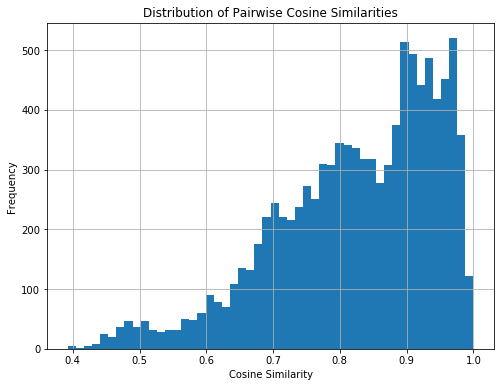

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(similarities.flatten(),bins=50)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Cosine Similarities')
plt.grid(True)
plt.show()

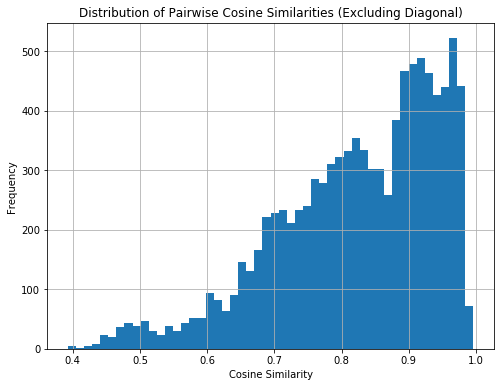

In [13]:
import numpy as np
similarities=np.round(similarities,4)

flattened_similarities = similarities.flatten()
flattened_similarities = flattened_similarities[flattened_similarities != 1.0] #removing diagonal elements

plt.figure(figsize=(8, 6))
plt.hist(flattened_similarities,bins=50)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Cosine Similarities (Excluding Diagonal)')
plt.grid(True)
plt.show()


In [88]:
max(flattened_similarities)

0.9867

In [ ]:
mask = np.triu(np.ones(similarities.shape), k=1)  # Mask to exclude diagonal and lower triangle
flattened_similarities = similarities[mask == 1]

In [57]:
image_embeddings_matrix = torch.cat(all_img_embds, dim=0)
image_embeddings_matrix

tensor([[ 0.3280,  0.3659, -0.1810,  ..., -0.4899,  0.3684,  0.0352],
        [ 0.2853,  0.0286,  0.2902,  ..., -0.4856, -0.0264,  0.2667],
        [ 0.2686,  0.2021, -0.4456,  ..., -0.7236,  0.5456,  0.0935],
        ...,
        [ 0.0921, -0.2244, -0.0349,  ..., -0.2817,  0.3925,  0.1247],
        [ 0.2701,  0.3929, -0.3485,  ..., -0.2357,  0.2601,  0.0666],
        [ 0.2795,  0.0140, -0.2511,  ..., -0.7416,  0.6222,  0.0351]],
       grad_fn=<CatBackward0>)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity


def calculating_cosine_similarities(embeddings):
   
    image_embeddings_array = embeddings.detach().numpy()
    similarities = cosine_similarity(image_embeddings_array)
    return similarities
    

In [16]:
cos_sim=calculating_cosine_similarities(image_embeddings_matrix)
print(cos_sim)

[[1.0000005  0.76022214 0.94600046 ... 0.74327457 0.930727   0.94147575]
 [0.76022214 1.0000002  0.6904698  ... 0.8378971  0.7478713  0.68445814]
 [0.94600046 0.6904698  1.0000002  ... 0.66923106 0.9137536  0.97883624]
 ...
 [0.74327457 0.8378971  0.66923106 ... 1.0000001  0.69810474 0.65517175]
 [0.930727   0.7478713  0.9137536  ... 0.69810474 1.0000002  0.9117024 ]
 [0.94147575 0.68445814 0.97883624 ... 0.65517175 0.9117024  1.0000002 ]]


In [78]:
mean_vector=torch.mean(image_embeddings_matrix,dim=1)
mean_vector=mean_vector.reshape(-1,1)
normalized_embeddings=image_embeddings_matrix-mean_vector
normalized_embeddings

tensor([[ 0.3334,  0.3713, -0.1756,  ..., -0.4845,  0.3738,  0.0406],
        [ 0.2966,  0.0398,  0.3015,  ..., -0.4744, -0.0152,  0.2779],
        [ 0.2705,  0.2040, -0.4436,  ..., -0.7217,  0.5475,  0.0954],
        ...,
        [ 0.0961, -0.2204, -0.0310,  ..., -0.2778,  0.3964,  0.1287],
        [ 0.2720,  0.3948, -0.3465,  ..., -0.2338,  0.2620,  0.0685],
        [ 0.2797,  0.0142, -0.2509,  ..., -0.7414,  0.6225,  0.0353]],
       grad_fn=<SubBackward0>)

In [79]:
#normalized_cosine_similarity
cos_sim_norm=calculating_cosine_similarities(normalized_embeddings)
print(cos_sim_norm)

[[1.0000001  0.76020086 0.9460207  ... 0.7432611  0.9307458  0.9415256 ]
 [0.76020086 1.0000004  0.6905325  ... 0.8379445  0.7479439  0.6845822 ]
 [0.9460207  0.6905325  1.0000002  ... 0.6692248  0.91375214 0.97884184]
 ...
 [0.7432611  0.8379445  0.6692248  ... 1.         0.6980989  0.65518403]
 [0.9307458  0.7479439  0.91375214 ... 0.6980989  1.0000002  0.9117078 ]
 [0.9415256  0.6845822  0.97884184 ... 0.65518403 0.9117078  1.        ]]


In [80]:
min(cos_sim_norm.flatten())

0.39262182

In [81]:
def show_distributions(score):
    similarities=np.round(score,4)

    flattened_similarities = similarities.flatten()
    flattened_similarities = flattened_similarities[flattened_similarities != 1.0000] #removing diagonal elements

    plt.figure(figsize=(8, 6))
    plt.hist(flattened_similarities,bins=50)
    plt.xlabel('Normalized Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Normalized Pairwise Cosine Similarities while dim=0')
    plt.grid(True)
    plt.show()





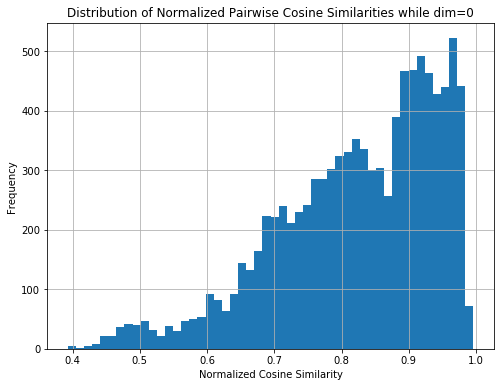

In [82]:
#normalized_distributions
show_distributions(cos_sim_norm)

In [62]:
a = torch.randn(4, 3)
print(a)
b=torch.mean(a, 1)
print(b)
b_reshaped = b.view(-1, 1)
diff=a-b_reshaped
print(diff)
print(b_reshaped.shape)


tensor([[ 0.5108, -1.7877, -0.8459],
        [-0.8026, -0.0094, -0.3568],
        [ 0.1120, -1.0091,  0.6086],
        [-1.8212,  0.1400,  1.4077]])
tensor([-0.7076, -0.3896, -0.0962, -0.0912])
tensor([[ 1.2184, -1.0801, -0.1383],
        [-0.4130,  0.3802,  0.0328],
        [ 0.2082, -0.9130,  0.7048],
        [-1.7301,  0.2312,  1.4989]])
torch.Size([4, 1])
